
# <div style="text-align: right"> Movie Sentiment </div>

---

<div style="text-align: right"> Geoff Counihan - Oct 29, 2017 </div>

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer

In [11]:
df = pd.read_csv('./data/labeledTrainData.tsv',sep='\t')

In [12]:
idx = .7*len(df)
train = df[:int(idx)]
test = df[int(idx):]

In [16]:
print('There are {} rows and {} cols in training set'.format(*train.shape))
print('There are {} rows and {} cols in training set'.format(*test.shape))

There are 17500 rows and 3 cols in training set
There are 7500 rows and 3 cols in training set


#### Example reviews

In [53]:
print(train['review'].iloc[1])

\The Classic War of the Worlds\" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \"critics\" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \"critics\". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \"critics\" perceive to be its shortcomings."


In [23]:
vectorizer = CountVectorizer()
features = vectorizer.fit_transform(train.review)
test_features = vectorizer.transform(test.review)
i = 45000
j = 10
words = vectorizer.get_feature_names()[i:i+10]
pd.DataFrame(features[j:j+7,i:i+10].todense(), columns=words)

,producer,producer9and,producers,produces,producing,product,production,productions,productive,productively
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0


In [26]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB()
model1.fit(features, train.sentiment)
pred1 = model1.predict_proba(test_features)

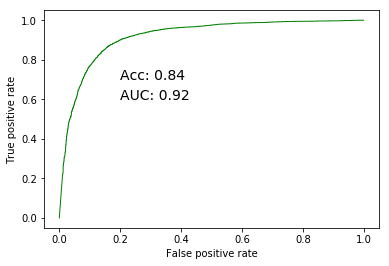

In [64]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

def performance(y_true, pred, color="g", ann=True):
    acc = accuracy_score(y_true, pred[:,1] > 0.5)
    auc = roc_auc_score(y_true, pred[:,1])
    fpr, tpr, thr = roc_curve(y_true, pred[:,1])
    plt.plot(fpr, tpr, color, linewidth="1")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    if ann:
        plt.annotate("Acc: %0.2f" % acc, (0.2,0.7), size=14)
        plt.annotate("AUC: %0.2f" % auc, (0.2,0.6), size=14)

performance(test.sentiment, pred1)

#### Experiment with differrent reviews

In [41]:
review = 'what a terrific movie!'

In [43]:
review = 'though I thought the movie was good at the beginning, \
it really sucked by the end'

In [45]:
review = 'started out bad but turned out to be a wonderful movie'

In [46]:
if model1.predict(vectorizer.transform([review]))[0] == 0:
    print('Bad movie')
else:
    print('Good movie')

Bad movie


#### tf-idf

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(train.review) 

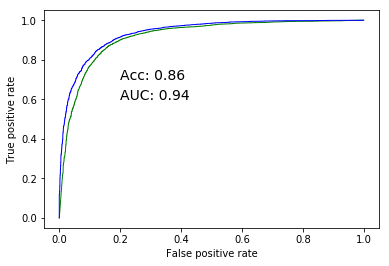

In [65]:
model2 = MultinomialNB()
model2.fit(features, train.sentiment)
pred2 = model2.predict_proba(vectorizer.transform(test.review))
performance(test.sentiment, pred1, ann=False)
performance(test.sentiment, pred2, color="b")

#### Tune

In [79]:
def build_model(max_features=None, min_df=1, nb_alpha=1.0, return_preds=False):
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df)
    features = vectorizer.fit_transform(train.review)
    model = MultinomialNB(alpha=nb_alpha)
    model.fit(features, train.sentiment)
    pred = model.predict_proba(vectorizer.transform(test.review))
    res = {
        "max_features": max_features,
        "min_df": min_df,
        "nb_alpha": nb_alpha,
        "auc": roc_auc_score(test.sentiment, pred[:,1])
    }
    if return_preds:
        res['preds'] = pred
    return res

In [80]:
from itertools import product
param_values = {
    "max_features": [10000, 30000, 50000, None],
    "min_df": [1,2,3],
    "nb_alpha": [0.01, 0.1, 1.0]
    }
results = []
for p in product(*param_values.values()):
    res = build_model(**dict(zip(param_values.keys(), p)))
    results.append(res)
print (res)

{'max_features': None, 'min_df': 3, 'nb_alpha': 1.0, 'auc': 0.93551567625932996}


In [81]:
pd.DataFrame(results).sort_values('auc')

,auc,max_features,min_df,nb_alpha
18,0.923980,50000.0,1,0.01
27,0.924120,NaN,1,0.01
21,0.925842,50000.0,2,0.01
30,0.925842,NaN,2,0.01
15,0.926089,30000.0,3,0.01
24,0.926219,50000.0,3,0.01
33,0.926219,NaN,3,0.01
12,0.926316,30000.0,2,0.01
9,0.927362,30000.0,1,0.01
0,0.927555,10000.0,1,0.01


(0.5, 1)

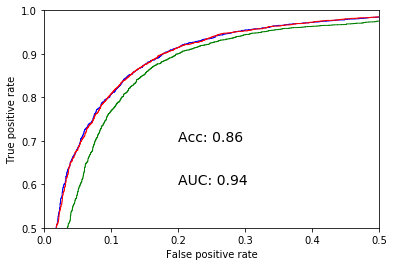

In [88]:
vectorizer = TfidfVectorizer(min_df=2)
features = vectorizer.fit_transform(train.review)
model3 = MultinomialNB(alpha=.5)
model3.fit(features, train.sentiment)
pred3 = model3.predict_proba(vectorizer.transform(test.review))
performance(test.sentiment, pred1, ann=False)
performance(test.sentiment, pred2, color="b", ann=False)
performance(test.sentiment, pred3, color="r")
plt.xlim(0,0.5)
plt.ylim(0.5,1)